<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C3/C3/W2/ungraded_labs/C3_W2_Lab_2_sarcasm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [23]:
import json
import numpy as np
import tensorflow as tf

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
vocab_size = 10000
embedding_dim = 16
max_length = 10
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [26]:
with open('assets/sarcasm.json', 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [27]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]


In [28]:
# Let's check the shapes of our data
print(len(training_sentences), len(training_labels))
print(len(testing_sentences), len(testing_labels))

20000 20000
6709 6709


In [29]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token= oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [30]:
word_index = tokenizer.word_index

In [33]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating=trunc_type)

In [34]:
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

In [35]:
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                            tf.keras.layers.GlobalAveragePooling1D(),
                            tf.keras.layers.Dense(24, activation = 'relu'),
                            tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [36]:
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 16)            160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [38]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs = num_epochs, validation_data= (testing_padded, testing_labels))

2021-09-06 16:44:15.132205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-06 16:44:15.164794: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz


Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.5055 - accuracy: 0.7443 - val_loss: 0.3688 - val_accuracy: 0.8414
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2760 - accuracy: 0.8902 - val_loss: 0.3497 - val_accuracy: 0.8517
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.2015 - accuracy: 0.9244 - val_loss: 0.3748 - val_accuracy: 0.8498
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 0.1583 - accuracy: 0.9435 - val_loss: 0.4277 - val_accuracy: 0.8402
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1307 - accuracy: 0.9548 - val_loss: 0.4780 - val_accuracy: 0.8341
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1086 - accuracy: 0.9632 - val_loss: 0.5531 - val_accuracy: 0.8299
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0923 - accuracy: 0.9704 - val_loss: 0.6089 - val_accuracy: 0.8249
Epoch 

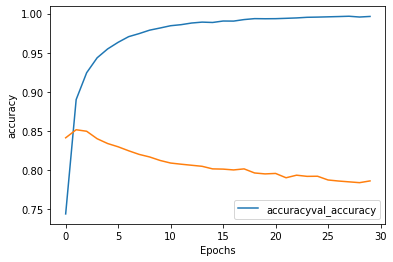

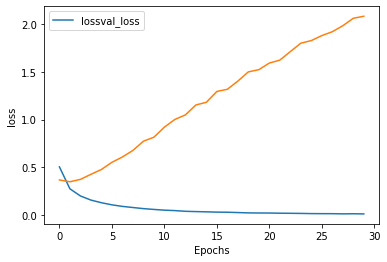

In [42]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string + 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [48]:
reverse_word_index = {v:k for k,v in word_index.items()}

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print()
print(training_sentences[0])
print(training_labels[0])

former <OOV> store clerk sues over secret 'black <OOV> for

former versace store clerk sues over secret 'black code' for minority shoppers
0


In [49]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_size)

(10000, 16)


In [50]:
import io

out_v = io.open('vecs.tsv', 'w', encoding = 'utf-8')
out_m = io.open('meta.tsv', 'w', encoding = 'utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [56]:
sentence = ["stock analysts confused, frightened by boar market", "game of thrones season finale showing this sunday night"]
sequence = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequence, maxlen= max_length, padding = padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1.000000e+00]
 [7.333844e-16]]
